In [58]:
# pip install WordCloud
# pip install WordCloud
# pip install WordCloud

In [59]:
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup
import markdown
import string
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

pd.set_option('display.max_columns', None)

def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Function to remove Markdown
def remove_markdown(text):
    html = markdown.markdown(text)
    return BeautifulSoup(html+ "html.parser").get_text()

def clean_row(row):
    return row.apply(lambda x: remove_markdown(remove_html_tags(x)) if isinstance(x, str) else x)

def clean_text(text):
    text = re.sub(r'-', ' ', text)
    text = re.sub(r'#', 'unique_column_heading', text)
    text = re.sub(r'None', 'unique_column_heading', text)
    text = re.sub(r'<strong>', '', text)
    text = re.sub(r'</strong>', ' ', text)
    text = re.sub(r'<em>', ' ', text)
    text = re.sub(r'</em>', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Replace spaces with dashes
    text = re.sub(r'\s+', '-', text)
    return text

def rename_duplicate_columns(mhs_df):
    cols = pd.Series(mhs_df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    mhs_df.columns = cols
    return mhs_df

def preprocess_df(df):
    df = df.astype(str)
    df = rename_duplicate_columns(df)
    df = df.reset_index(drop=True)
    return df

def merge_columns(df: pd.DataFrame) -> pd.DataFrame:
    merged_columns = {}

    for col in df.columns:
        if col in merged_columns:
            merged_columns[col] = merged_columns[col].fillna('') + ' ' + df[col].fillna('')
        else:
            merged_columns[col] = df[col].fillna('')

    merged_df = pd.DataFrame(merged_columns)

    return merged_df

def reset_index_with_string(df, string):
    df = df.reset_index(drop=True)
    df.index = [f"{string}{i}" for i in df.index.astype(str)]
    return df

def fix_dates_in_col(mhs_df, column_name):
    mhs_df[column_name] = pd.to_datetime(mhs_df[column_name], format="mixed")
    mhs_df[column_name] = mhs_df[column_name].dt.strftime('%m/%d/%Y')
    return mhs_df

def no_data_columns(df):
    empty_or_nan_columns = []
    
    for column in df.columns:
        # Check if the column is empty
        if df[column].empty:
            empty_or_nan_columns.append(column)
        # Check if all values are NaN or the string 'nan'
        elif df[column].apply(lambda x: pd.isna(x) or x == 'nan').all():
            empty_or_nan_columns.append(column)
    
    return empty_or_nan_columns

In [60]:
column_mapping = {
    'are-you-self-employed' : 'self-employed', 
    'how-many-employees-does-your-company-or-organization-have' : 'num-employees', 
    'is-your-employer-primarily-a-tech-companyorganization' : 'tech-employer', 
    'is-your-primary-role-within-your-company-related-to-techit' : 'tech-role', 
    'does-your-employer-provide-mental-health-benefits-as-part-of-healthcare-coverage' : 'has-mental-health-benefits', 
    'do-you-know-the-options-for-mental-health-care-available-under-your-employer-provided-health-coverage' : 'know-mental-health-options', 
    'has-your-employer-ever-formally-discussed-mental-health-for-example-as-part-of-a-wellness-campaign-or-other-official-communication' : 'discussed-mental-health', 
    'does-your-employer-offer-resources-to-learn-more-about-mental-health-disorders-and-options-for-seeking-help' : 'has-mental-health-resources', 
    'is-your-anonymity-protected-if-you-choose-to-take-advantage-of-mental-health-or-substance-abuse-treatment-resources-provided-by-your-employer' : 'anonymity-protected', 
    'if-a-mental-health-issue-prompted-you-to-request-a-medical-leave-from-work-how-easy-or-difficult-would-it-be-to-ask-for-that-leave' : 'mental-health-leave-ease', 
    'would-you-feel-more-comfortable-talking-to-your-coworkers-about-your-physical-health-or-your-mental-health' : 'comfort-discussing-health', 
    'would-you-feel-comfortable-discussing-a-mental-health-issue-with-your-direct-supervisors' : 'discuss-mental-health-supervisor', 
    'have-you-ever-discussed-your-mental-health-with-your-employer' : 'discussed-mental-health-employer', 
    'describe-the-conversation-you-had-with-your-employer-about-your-mental-health-including-their-reactions-and-what-actions-were-taken-to-address-your-mental-health-issuequestions' : 'mental-health-talk-employer', 
    'would-you-feel-comfortable-discussing-a-mental-health-issue-with-your-coworkers' : 'discuss-mental-health-coworkers', 
    'have-you-ever-discussed-your-mental-health-with-coworkers' : 'discussed-mental-health-coworkers', 
    'describe-the-conversation-with-coworkers-you-had-about-your-mental-health-including-their-reactions' : 'mental-health-talk-coworkers', 
    'have-you-ever-had-a-coworker-discuss-their-or-another-coworkers-mental-health-with-you' : 'coworker-mental-health-discussion', 
    'describe-the-conversation-your-coworker-had-with-you-about-their-mental-health-please-do-not-use-names' : 'coworker-mental-health-talk', 
    'overall-how-much-importance-does-your-employer-place-on-physical-health' : 'importance-physical-health', 
    'overall-how-much-importance-does-your-employer-place-on-mental-health' : 'importance-mental-health', 
    'do-you-have-medical-coverage-private-insurance-or-state-provided-that-includes-treatment-of-mental-health-disorders' : 'mental-health-coverage', 
    'do-you-know-local-or-online-resources-to-seek-help-for-a-mental-health-issue' : 'know-mental-health-resources', 
    'if-you-have-been-diagnosed-or-treated-for-a-mental-health-disorder-do-you-ever-reveal-this-to-clients-or-business-contacts' : 'reveal-mental-health-clients', 
    'if-you-have-revealed-a-mental-health-disorder-to-a-client-or-business-contact-how-has-this-affected-you-or-the-relationship' : 'effect-reveal-mental-health', 
    'if-you-have-been-diagnosed-or-treated-for-a-mental-health-disorder-do-you-ever-reveal-this-to-coworkers-or-employees' : 'reveal-mental-health-coworkers', 
    'if-you-have-revealed-a-mental-health-disorder-to-a-coworker-or-employee-how-has-this-impacted-you-or-the-relationship' : 'impact-reveal-mental-health', 
    'do-you-believe-your-productivity-is-ever-affected-by-a-mental-health-issue' : 'productivity-mental-health', 
    'if-yes-what-percentage-of-your-work-time-time-performing-primary-or-secondary-job-functions-is-affected-by-a-mental-health-issue' : 'percentage-affected-mental-health', 
    'do-you-have-previous-employers' : 'previous-employers', 
    'was-your-employer-primarily-a-tech-companyorganization' : 'previous-tech-employer', 
    'have-your-previous-employers-provided-mental-health-benefits' : 'previous-mental-health-benefits', 
    'were-you-aware-of-the-options-for-mental-health-care-provided-by-your-previous-employers' : 'aware-previous-mental-health-options', 
    'did-your-previous-employers-ever-formally-discuss-mental-health-as-part-of-a-wellness-campaign-or-other-official-communication' : 'discussed-mental-health-previous', 
    'did-your-previous-employers-provide-resources-to-learn-more-about-mental-health-disorders-and-how-to-seek-help' : 'previous-mental-health-resources', 
    'was-your-anonymity-protected-if-you-chose-to-take-advantage-of-mental-health-or-substance-abuse-treatment-resources-with-previous-employers' : 'previous-anonymity-protected', 
    'would-you-have-felt-more-comfortable-talking-to-your-previous-employer-about-your-physical-health-or-your-mental-health' : 'previous-comfort-discussing-health', 
    'would-you-have-been-willing-to-discuss-your-mental-health-with-your-direct-supervisors' : 'previous-discuss-mental-health-supervisor', 
    'did-you-ever-discuss-your-mental-health-with-your-previous-employer' : 'previous-discussed-mental-health', 
    'describe-the-conversation-you-had-with-your-previous-employer-about-your-mental-health-including-their-reactions-and-actions-taken-to-address-your-mental-health-issuequestions' : 'previous-mental-health-talk-employer', 
    'would-you-have-been-willing-to-discuss-your-mental-health-with-your-coworkers-at-previous-employers' : 'previous-discuss-mental-health-coworkers', 
    'did-you-ever-discuss-your-mental-health-with-a-previous-coworkers' : 'previous-discussed-mental-health-coworkers', 
    'describe-the-conversation-you-had-with-your-previous-coworkers-about-your-mental-health-including-their-reactions' : 'previous-mental-health-talk-coworkers', 
    'did-you-ever-have-a-previous-coworker-discuss-their-or-another-coworkers-mental-health-with-you' : 'previous-coworker-mental-health-discussion', 
    'describe-the-conversation-your-coworker-had-with-you-about-their-mental-health-please-do-not-use-names1' : 'previous-coworker-mental-health-talk', 
    'overall-how-much-importance-did-your-previous-employer-place-on-physical-health' : 'previous-importance-physical-health', 
    'overall-how-much-importance-did-your-previous-employer-place-on-mental-health' : 'previous-importance-mental-health', 
    'do-you-currently-have-a-mental-health-disorder' : 'current-mental-health-disorder', 
    'have-you-ever-been-diagnosed-with-a-mental-health-disorder' : 'diagnosed-mental-health', 
    'anxiety-disorder-generalized-social-phobia-etc' : 'anxiety-disorder', 
    'mood-disorder-depression-bipolar-disorder-etc' : 'mood-disorder', 
    'psychotic-disorder-schizophrenia-schizoaffective-etc' : 'psychotic-disorder', 
    'eating-disorder-anorexia-bulimia-etc' : 'eating-disorder', 
    'attention-deficit-hyperactivity-disorder' : 'adhd', 
    'personality-disorder-borderline-antisocial-paranoid-etc' : 'personality-disorder', 
    'obsessive-compulsive-disorder' : 'ocd', 
    'post-traumatic-stress-disorder' : 'ptsd', 
    'stress-response-syndromes' : 'stress-response', 
    'dissociative-disorder' : 'dissociative-disorder', 
    'substance-use-disorder' : 'substance-use', 
    'addictive-disorder' : 'addictive-disorder', 
    'other' : 'other', 
    'anxiety-disorder-generalized-social-phobia-etc1' : 'anxiety-disorder1', 
    'mood-disorder-depression-bipolar-disorder-etc1' : 'mood-disorder1', 
    'psychotic-disorder-schizophrenia-schizoaffective-etc1' : 'psychotic-disorder1', 
    'eating-disorder-anorexia-bulimia-etc1' : 'eating-disorder1', 
    'attention-deficit-hyperactivity-disorder1' : 'adhd1', 
    'personality-disorder-borderline-antisocial-paranoid-etc1' : 'personality-disorder1', 
    'obsessive-compulsive-disorder1' : 'ocd1', 
    'post-traumatic-stress-disorder' : 'ptsd1', 
    'stress-response-syndromes1' : 'stress-response1', 
    'dissociative-disorder1' : 'dissociative-disorder1', 
    'substance-use-disorder1' : 'substance-use1', 
    'addictive-disorder1' : 'addictive-disorder1', 
    'other1' : 'other1', 
    'anxiety-disorder-generalized-social-phobia-etc2' : 'anxiety-disorder2', 
    'mood-disorder-depression-bipolar-disorder-etc2' : 'mood-disorder2', 
    'psychotic-disorder-schizophrenia-schizoaffective-etc2' : 'psychotic-disorder2', 
    'eating-disorder-anorexia-bulimia-etc2' : 'eating-disorder2', 
    'attention-deficit-hyperactivity-disorder2' : 'adhd2', 
    'personality-disorder-borderline-antisocial-paranoid-etc2' : 'personality-disorder2', 
    'obsessive-compulsive-disorder2' : 'ocd2', 
    'post-traumatic-stress-disorder1' : 'ptsd2', 
    'stress-response-syndromes2' : 'stress-response2', 
    'dissociative-disorder2' : 'dissociative-disorder2', 
    'substance-use-disorder2' : 'substance-use2', 
    'addictive-disorder2' : 'addictive-disorder2', 
    'other2' : 'other2', 
    'have-you-had-a-mental-health-disorder-in-the-past' : 'past-mental-health-disorder', 
    'have-you-ever-sought-treatment-for-a-mental-health-disorder-from-a-mental-health-professional' : 'sought-treatment', 
    'do-you-have-a-family-history-of-mental-illness' : 'family-history-mental-illness', 
    'if-you-have-a-mental-health-disorder-how-often-do-you-feel-that-it-interferes-with-your-work-when-being-treated-effectively' : 'mental-health-interference-treated', 
    'if-you-have-a-mental-health-disorder-how-often-do-you-feel-that-it-interferes-with-your-work-when-not-being-treated-effectively-ie-when-you-are-experiencing-symptoms' : 'mental-health-interference-untreated', 
    'have-your-observations-of-how-another-individual-who-discussed-a-mental-health-issue-made-you-less-likely-to-reveal-a-mental-health-issue-yourself-in-your-current-workplace' : 'observations-mental-health-discussion', 
    'how-willing-would-you-be-to-share-with-friends-and-family-that-you-have-a-mental-illness' : 'share-mental-illness', 
    'would-you-be-willing-to-bring-up-a-physical-health-issue-with-a-potential-employer-in-an-interview' : 'physical-health-interview', 
    'why-or-why-not' : 'physical-health-reason', 
    'would-you-bring-up-your-mental-health-with-a-potential-employer-in-an-interview' : 'mental-health-interview', 
    'why-or-why-not1' : 'mental-health-reason', 
    'are-you-openly-identified-at-work-as-a-person-with-a-mental-health-issue' : 'open-mental-health', 
    'has-being-identified-as-a-person-with-a-mental-health-issue-affected-your-career' : 'mental-health-career', 
    'how-has-it-affected-your-career' : 'mental-health-career-effect', 
    'if-they-knew-you-suffered-from-a-mental-health-disorder-how-do-you-think-that-your-team-membersco-workers-would-react' : 'team-reaction', 
    'have-you-observed-or-experienced-an-unsupportive-or-badly-handled-response-to-a-mental-health-issue-in-your-current-or-previous-workplace' : 'unsupportive-response', 
    'describe-the-circumstances-of-the-badly-handled-or-unsupportive-response' : 'unsupportive-response-details', 
    'have-you-observed-or-experienced-a-supportive-or-well-handled-response-to-a-mental-health-issue-in-your-current-or-previous-workplace' : 'supportive-response', 
    'describe-the-circumstances-of-the-supportive-or-well-handled-response' : 'supportive-response-details', 
    'overall-how-well-do-you-think-the-tech-industry-supports-employees-with-mental-health-issues' : 'industry-support', 
    'briefly-describe-what-you-think-the-industry-as-a-whole-andor-employers-could-do-to-improve-mental-health-support-for-employees' : 'improve-industry-support', 
    'if-there-is-anything-else-you-would-like-to-tell-us-that-has-not-been-covered-by-the-survey-questions-please-use-this-space-to-do-so' : 'additional-comments', 
    'would-you-be-willing-to-talk-to-one-of-us-more-extensively-about-your-experiences-with-mental-health-issues-in-the-tech-industry-note-that-all-interview-responses-would-be-used-anonymously-and-only-with-your-permission' : 'interview-mental-health', 
    'what-is-your-age' : 'age', 
    'what-is-your-gender' : 'gender', 
    'what-country-do-you-live-in' : 'country-live', 
    'what-us-state-or-territory-do-you-live-in' : 'us-state-live', 
    'what-is-your-race' : 'race', 
    'other3' : 'other3', 
    'what-country-do-you-work-in' : 'country-work', 
    'what-us-state-or-territory-do-you-work-in' : 'us-state-work', 
    'have-you-been-diagnosed-with-covid-19' : 'covid-19-diagnosis', 
    'response-type' : 'response-type', 
    'start-date-utc' : 'start-date', 
    'submit-date-utc' : 'submit-date', 
    'network-id' : 'network-id', 
    'tags' : 'tags'
}

cols_kept=['year','country-live','race','gender','age',
           'anxiety-disorder','anxiety-disorder1','anxiety-disorder2',
           'mood-disorder','mood-disorder1','mood-disorder2',
           'psychotic-disorder','psychotic-disorder1','psychotic-disorder2',
           'eating-disorder','eating-disorder1','eating-disorder2',
           'adhd','adhd1','adhd2',
           'personality-disorder','personality-disorder1','personality-disorder2',
           'ocd','ocd1','ocd2',
           'ptsd1','ptsd2',
           'stress-response','stress-response1','stress-response2',
           'dissociative-disorder','dissociative-disorder1','dissociative-disorder2',
           'substance-use','substance-use1','substance-use2',
           'addictive-disorder','addictive-disorder1','addictive-disorder2',
           'other','other1','other2']

# For 2020
mhs_2020 = pd.read_csv("resources/2020.csv", index_col=False)
mhs_2020["year"] = 2020
mhs_2020.columns = [clean_text(col) for col in mhs_2020.columns]
# mhs_2020 = mhs_2020.apply(clean_row, axis=1)
mhs_2020 = preprocess_df(mhs_2020)
mhs_2020.rename(columns=column_mapping, inplace=True)
mhs_2020_fin=mhs_2020 #[cols_kept]
display(mhs_2020_fin.info())
column_names_2020 = mhs_2020_fin.columns.tolist()
print(len(column_names_2020))

# For 2021
mhs_2021 = pd.read_csv("resources/2021.csv", index_col=False)
mhs_2021["year"] = 2021
mhs_2021.columns = [clean_text(col) for col in mhs_2021.columns]
# mhs_2021 = mhs_2021.apply(clean_row, axis=1)
mhs_2021 = preprocess_df(mhs_2021)
mhs_2021.rename(columns=column_mapping, inplace=True)
mhs_2021_fin=mhs_2021 #[cols_kept]
display(mhs_2021_fin.info())
column_names_2021 = mhs_2021_fin.columns.tolist()
print(len(column_names_2021))

# For 2022
mhs_2022 = pd.read_csv("resources/2022.csv", index_col=False)
mhs_2022["year"] = 2022
mhs_2022.columns = [clean_text(col) for col in mhs_2022.columns]
# mhs_2022 = mhs_2022.apply(clean_row, axis=1)
mhs_2022 = preprocess_df(mhs_2022)
mhs_2022.rename(columns=column_mapping, inplace=True)
mhs_2022_fin=mhs_2022 #[cols_kept]
display(mhs_2022_fin.info())
column_names_2022 = mhs_2022_fin.columns.tolist()
print(len(column_names_2022))

# For 2023
mhs_2023 = pd.read_csv("resources/2023.csv", index_col=False)
mhs_2023["year"] = 2023
mhs_2023.columns = [clean_text(col) for col in mhs_2023.columns]
# mhs_2023 = mhs_2023.apply(clean_row, axis=1)
mhs_2023 = preprocess_df(mhs_2023)
mhs_2023.rename(columns=column_mapping, inplace=True)
mhs_2023_fin=mhs_2023 #[cols_kept]
display(mhs_2023_fin.info())
column_names_2023 = mhs_2023_fin.columns.tolist()
print(len(column_names_2023))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Columns: 121 entries, uniquecolumnheading to year
dtypes: object(121)
memory usage: 170.3+ KB


None

121
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Columns: 125 entries, uniquecolumnheading to year
dtypes: object(125)
memory usage: 128.1+ KB


None

125
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Columns: 125 entries, uniquecolumnheading to year
dtypes: object(125)
memory usage: 160.3+ KB


None

125
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Columns: 125 entries, uniquecolumnheading to year
dtypes: object(125)
memory usage: 6.0+ KB


None

125


In [61]:
mhs_2020_fin = reset_index_with_string(mhs_2020_fin, "2020_")
mhs_2021_fin = reset_index_with_string(mhs_2021_fin, "2021_")
mhs_2022_fin = reset_index_with_string(mhs_2022_fin, "2022_")
mhs_2023_fin = reset_index_with_string(mhs_2023_fin, "2023_")

In [62]:
merged_mhs = pd.concat([mhs_2020_fin, mhs_2021_fin, mhs_2022_fin, mhs_2023_fin], axis=0)
merged_mhs.to_csv("resources/merged_mhs_dc.csv", index=False)

In [63]:
merged_mhs.convert_dtypes()
merged_mhs.dtypes

# merged_mhs.plot(kind='bar', x='year', y='age')
# plt.show()

uniquecolumnheading                           object
self-employed                                 object
num-employees                                 object
tech-employer                                 object
tech-role                                     object
has-mental-health-benefits                    object
know-mental-health-options                    object
discussed-mental-health                       object
has-mental-health-resources                   object
anonymity-protected                           object
mental-health-leave-ease                      object
comfort-discussing-health                     object
discuss-mental-health-supervisor              object
discussed-mental-health-employer              object
mental-health-talk-employer                   object
discuss-mental-health-coworkers               object
discussed-mental-health-coworkers             object
mental-health-talk-coworkers                  object
coworker-mental-health-discussion             

In [64]:
# merged_mhs=merged_mhs.reset_index()

cols_to_concat=["anxiety-disorder",'anxiety-disorder1','anxiety-disorder2',
           'mood-disorder','mood-disorder1','mood-disorder2',
           'psychotic-disorder','psychotic-disorder1','psychotic-disorder2',
           'eating-disorder','eating-disorder1','eating-disorder2',
           'adhd','adhd1','adhd2',
           'personality-disorder','personality-disorder1','personality-disorder2',
           'ocd','ocd1','ocd2',
           'ptsd1','ptsd2', 'post-traumatic-stress-disorder_1',
           'stress-response','stress-response1','stress-response2',
           'dissociative-disorder','dissociative-disorder1','dissociative-disorder2',
           'substance-use','substance-use1','substance-use2',
           'addictive-disorder','addictive-disorder1','addictive-disorder2',
           'other','other1','other2']

concatenated_series = merged_mhs[cols_to_concat].apply(lambda row: '| '.join(str(val) for val in row), axis=1)

merged_mhs['disorders'] = concatenated_series
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("nan|", '')
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("nan", '')
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace(", ", '||')
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace(" ", '')
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("||", ', ')
merged_mhs.drop(columns=cols_to_concat, inplace=True)
qualitative_cols = ["additional-comments","improve-industry-support","supportive-response-details","unsupportive-response-details","mental-health-reason","physical-health-reason"]
merged_mhs.drop(columns=qualitative_cols, inplace=True)

/var/folders/lp/71p77wmn3x7dxlg4mnwx61cw0000gq/T/ipykernel_52382/2792223523.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_mhs['disorders'] = concatenated_series


In [65]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [66]:
merged_mhs['num-employees'] = merged_mhs['num-employees'].replace({
    "": '1',
    "nan": '1',
    "1-5": '1',
    "5-Jan": '1',
    "6-25": '5',
    "25-Jun": '5',
    "26-100": '25',
    "101-500": '100',
    "100-500": '100',
    "501-1000": '500',
    "500-1000": '500',
    "More than 1000": '1000'
})
merged_mhs['tech-employer'] = merged_mhs['tech-employer'].replace({
    "nan": "True",
    "0.0": "False",
    "1.0": "True",
})
merged_mhs['tech-role'] = merged_mhs['tech-role'].replace({
    "nan": "True",
    "0.0": "False",
    "1.0": "True",
})
merged_mhs['has-mental-health-benefits'] = merged_mhs['has-mental-health-benefits'].replace({
    "nan": "False",
    "No": "False",
    "Yes": "True",
    "I don't know": "False",
    "Not eligible for coverage / NA": "False"
})

merged_mhs['know-mental-health-options'] = merged_mhs['know-mental-health-options'].replace({
    "nan": "False",
    "No": "False",
    "Yes": "True",
    "I don't know": "False"
})

merged_mhs['discussed-mental-health'] = merged_mhs['discussed-mental-health'].replace({
    "nan": "False",
    "No": "False",
    "Yes": "True",
    "I don't know": "False"
})
merged_mhs['has-mental-health-resources'] = merged_mhs['has-mental-health-resources'].replace({
    "nan": "False",
    "No": "False",
    "Yes": "True",
    "I don't know": "False"
})
merged_mhs['anonymity-protected'] = merged_mhs['anonymity-protected'].replace({
    "nan": "False",
    "No": "False",
    "Yes": "True",
    "I don't know": "False"
})

merged_mhs['self-employed'] = merged_mhs['self-employed'].replace({
    "nan": "False",
    "0": "False",
    "1": "True",
})

merged_mhs['mental-health-coverage'] = merged_mhs['mental-health-coverage'].replace({
    "nan": "False",
    "0.0": "False",
    "1.0": "True",
})

merged_mhs['mental-health-leave-ease'] = merged_mhs['mental-health-leave-ease'].replace({
    "nan": "0",
    "Very easy": "1",
    "Somewhat easy": "2",
    "Neither easy nor difficult": "3",
    "Somewhat difficult": "4",
    "Difficult": "5",
    "I don't know": "0"
})

merged_mhs['comfort-discussing-health'] = merged_mhs['comfort-discussing-health'].replace({
    "nan": "0",
    "Physical health": "1",
    "Mental health": "2",
    "Same level of comfort for each": "3"
})

merged_mhs['discuss-mental-health-supervisor'] = merged_mhs['discuss-mental-health-supervisor'].replace({
    "nan": "False",
    "Yes": "True",
    "Maybe": "False",
    "No": "False"
})

merged_mhs['discussed-mental-health-employer'] = merged_mhs['discussed-mental-health-employer'].replace({
    "nan": "False",
    "Yes": "True",
    "Maybe": "False",
    "No": "False"
})

merged_mhs['discuss-mental-health-coworkers'] = merged_mhs['discuss-mental-health-coworkers'].replace({
    "nan": "False",
    "Yes": "True",
    "Maybe": "False",
    "No": "False"
})

merged_mhs['discussed-mental-health-coworkers'] = merged_mhs['discussed-mental-health-coworkers'].replace({
    "nan": "False",
    "Yes": "True",
    "Maybe": "False",
    "No": "False"
})
merged_mhs['coworker-mental-health-discussion'] = merged_mhs['coworker-mental-health-discussion'].replace({
    "nan": "False",
    "Yes": "True",
    "Maybe": "False",
    "No": "False"
})
merged_mhs['importance-physical-health'] = merged_mhs['importance-physical-health'].replace({
    "nan": "5",
    "1.0": "1",
    "2.0": "2",
    "3.0": "3",
    "4.0": "4",
    "5.0": "5",
    "6.0": "6",
    "7.0": "7",
    "8.0": "8",
    "9.0": "9",
    "10.0": "10"
})

merged_mhs['importance-mental-health'] = merged_mhs['importance-mental-health'].replace({
    "nan": "5",
    "1.0": "1",
    "2.0": "2",
    "3.0": "3",
    "4.0": "4",
    "5.0": "5",
    "6.0": "6",
    "7.0": "7",
    "8.0": "8",
    "9.0": "9",
    "10.0": "10"
})

merged_mhs = fix_dates_in_col(merged_mhs, 'start-date')
merged_mhs = fix_dates_in_col(merged_mhs, 'submit-date')

merged_mhs['race'] = merged_mhs['race'].str.replace("More than one of the above", 'Multi')
merged_mhs['race'] = merged_mhs['race'].str.replace("nan", 'Unknown')
merged_mhs['race'] = merged_mhs['race'].str.replace("I prefer not to answer", 'Unknown')

merged_mhs['gender'] = merged_mhs['gender'].str.replace("afab non-binary", 'Non-Binary')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("non-binary", 'Non-Binary')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("Non-binary/Agender", 'Non-Binary')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("Non-binary", 'Non-Binary')



merged_mhs['gender'] = merged_mhs['gender'].str.replace("female", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("Female (cis)", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("FEMALE", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("Female, cis-gendered", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("Woman", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("woman", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("female, she/her", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("Female, she/her", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("f", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("F", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("Femaleemale", 'Female')

merged_mhs['gender'] = merged_mhs['gender'].str.replace("mostly male", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("cisgender male", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("MAle", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("MALE", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("Masculine", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("male/he/him", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace('Queer', 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace('varón', 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("mail", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace('man', 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace('Cis male', 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("cis-het male", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("cis male", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace('Cis Male', 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace('dude', 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace('homem cis', 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("male", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("FeMale", 'Female')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("M", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("Maleale", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("m", 'Male')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("FeMaleale", 'Female')

merged_mhs['gender'] = merged_mhs['gender'].str.replace("b", 'Unknown')
merged_mhs['gender'] = merged_mhs['gender'].str.replace("nan", 'Unknown')

merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("AnxietyDisorder(Generalized, Social, Phobia, etc)","Anxiety Disorder")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("MoodDisorder(Depression, BipolarDisorder, etc)","Mood Disorder")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("PsychoticDisorder(Schizophrenia, Schizoaffective, etc)","Psychotic Disorder")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("EatingDisorder(Anorexia, Bulimia, etc)","Eating Disorder")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("AttentionDeficitHyperactivityDisorder","ADHD")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("PersonalityDisorder(Borderline, Antisocial, Paranoid, etc)","Personality Disorder")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("Obsessive-CompulsiveDisorder","OCD")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("Post-traumaticStressDisorder","PTSD")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("StressResponseSyndromes","Stress Response Syndromes")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("DissociativeDisorder","Dissociative Disorder")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("SubstanceUseDisorder","Substance Use Disorder")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("AddictiveDisorder","Addiction")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("AutismSpectrumDisorder","Autism Spectrum Disorder")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("Autismspectrumdisorder","Autism Spectrum Disorder")
merged_mhs['disorders'] = merged_mhs['disorders'].str.replace("Notsure.MaybeamixofA, B, H","Not Sure")

merged_mhs['disorders'] = merged_mhs['disorders'].str.split('|')
merged_mhs = merged_mhs.explode('disorders', ignore_index=True)

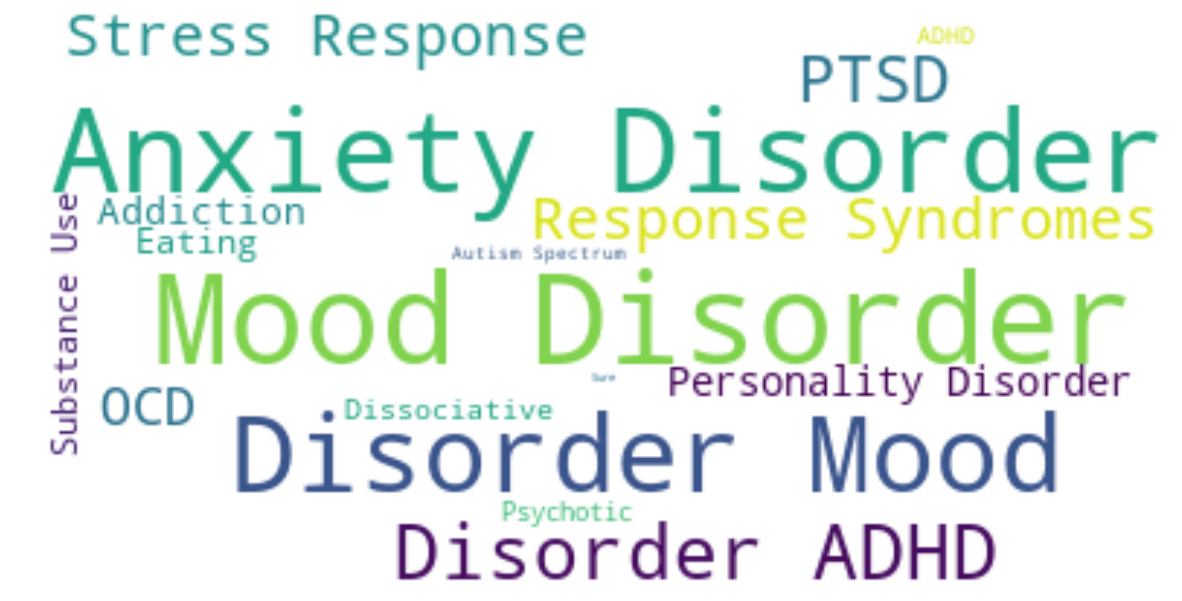

In [67]:
text = " ".join(i for i in merged_mhs['disorders'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [68]:
empty_columns = no_data_columns(merged_mhs)
merged_mhs.drop(columns=empty_columns, inplace=True)

In [69]:
merged_mhs_unique_vals={}
colnames=[]

def unique(list):
    unique_list = []
    for val in list:
        if val not in unique_list:
            unique_list.append(val)
    return unique_list

def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

count=1
column_names = merged_mhs.columns.tolist()

while count < len(column_names):
    mylist = merged_mhs[column_names[count]].tolist()
    unique_lst = unique(mylist)
    merged_mhs_unique_vals[column_names_2023[count]] = unique_lst
    count=count+1

merged_mhs_unique_vals

{'self-employed': ['True', 'False'],
 'num-employees': ['1', '1000', '500', '5', '25', '100'],
 'tech-employer': ['True', 'False'],
 'tech-role': ['True', 'False'],
 'has-mental-health-benefits': ['False', 'True'],
 'know-mental-health-options': ['False', 'True'],
 'discussed-mental-health': ['False', 'True'],
 'has-mental-health-resources': ['False', 'True'],
 'anonymity-protected': ['False', 'True'],
 'mental-health-leave-ease': ['0', '1', '2', '5', '3', '4'],
 'comfort-discussing-health': ['0', '1', '2', '3'],
 'discuss-mental-health-supervisor': ['False', 'True'],
 'discussed-mental-health-employer': ['False', '0.0', '1.0'],
 'mental-health-talk-employer': ['nan',
  'discussed anxiety disorder and desire to WFH more \nfrequently. they honored this request with no problem.',
  'awkwardness',
  'I had to take leave for several days due to a mood episode that caused me to be hospitalized. My boss was supportive and asked basically no questions.',
  'It was very difficult and uncomfort

In [70]:
merged_mhs

uniquecolumnheading self-employed num-employees  \
0     zwrffw6ykfo82ft1twvzwrffw6c6wsfv          True             1   
1     zhdmhaa8r0125c4zmoi7qzhdmtjrakhm          True             1   
2     zhdmhaa8r0125c4zmoi7qzhdmtjrakhm          True             1   
3     x4itwa9hnlw7qke4y5xibx4itwa9yzl5          True             1   
4     x3v3oimu5pn0043n8x3v3oizaybhwwto          True             1   
5     uyp6re7bhnyx6gez09uyp6re72z0e4e4          True             1   
6     u0nbmruq4qexmkk8zvqsu0nbmrh6he0e          True             1   
7     t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
8     t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
9     t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
10    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
11    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
12    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
13    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
14    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
15    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
16    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
17    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
18    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
19    t4ck9zq73fzi90rtcfgzu0ot4ck9zzub          True             1   
20    sics80avlof5gljw4fqrl7sics805x6i          True             1   
21    sics80avlof5gljw4fqrl7sics805x6i          True             1   
22    sics80avlof5gljw4fqrl7sics805x6i          True             1   
23    sics80avlof5gljw4fqrl7sics805x6i          True             1   
24    sics80avlof5gljw4fqrl7sics805x6i          True             1   
25    rd0ztpn1g47k7bhehrd0ztt4hk3qv0kp          True             1   
26    qxhj26vbyd7zlgbi1xqxhj26nalmk3sa          True             1   
27    ovu3jddsnn98sy4ebvvn4qovu3jdd7uh          True             1   
28    ovu3jddsnn98sy4ebvvn4qovu3jdd7uh          True             1   
29    ovu3jddsnn98sy4ebvvn4qovu3jdd7uh          True             1   
30    ovu3jddsnn98sy4ebvvn4qovu3jdd7uh          True             1   
31    ovu3jddsnn98sy4ebvvn4qovu3jdd7uh          True             1   
32    ovu3jddsnn98sy4ebvvn4qovu3jdd7uh          True             1   
33    ovu3jddsnn98sy4ebvvn4qovu3jdd7uh          True             1   
34    n3s4fql5huqq4xbl0zn3s4frtooalk67          True             1   
35    n3s4fql5huqq4xbl0zn3s4frtooalk67          True             1   
36    n0ipb1tctq9k410l9sn0ipb68ev006se          True             1   
37    myzeqlqdjj319ypg8nftamyz3dn3ml8s          True             1   
38    myzeqlqdjj319ypg8nftamyz3dn3ml8s          True             1   
39    myzeqlqdjj319ypg8nftamyz3dn3ml8s          True             1   
40    myzeqlqdjj319ypg8nftamyz3dn3ml8s          True             1   
41    mu3cdar3yry477ynlmu3cdai1wbyk31a          True             1   
42    mu3cdar3yry477ynlmu3cdai1wbyk31a          True             1   
43    esym9pfy14akftsesym9wo19gkswdcqw          True             1   
44    esym9pfy14akftsesym9wo19gkswdcqw          True             1   
45    esym9pfy14akftsesym9wo19gkswdcqw          True             1   
46    esym9pfy14akftsesym9wo19gkswdcqw          True             1   
47    esym9pfy14akftsesym9wo19gkswdcqw          True             1   
48    dx2tw3pvtbym9se8vdx2twrzdk3jmlh9          True             1   
49    dx2tw3pvtbym9se8vdx2twrzdk3jmlh9          True             1   
50    dx2tw3pvtbym9se8vdx2twrzdk3jmlh9          True             1   
51    dx2tw3pvtbym9se8vdx2twrzdk3jmlh9          True             1   
52    dx2tw3pvtbym9se8vdx2twrzdk3jmlh9          True             1   
53    ccee8wjm4p0y3j90quccee8wvvu0go9u          True             1   
54    ccee8wjm4p0y3j90quccee8wvvu0go9u          True             1   
55    ccee8wjm4p0y3j90quccee8wvvu0go9u          True             1   
56    bfdl5izw77unrt9oqebfdl5